In [1]:
import scipy.io
import matplotlib.pyplot as plt
Xmat = scipy.io.loadmat('X.mat')
Ymat = scipy.io.loadmat('Y.mat')

In [2]:
X = Xmat["X"]
GT = Ymat['Y']

In [3]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

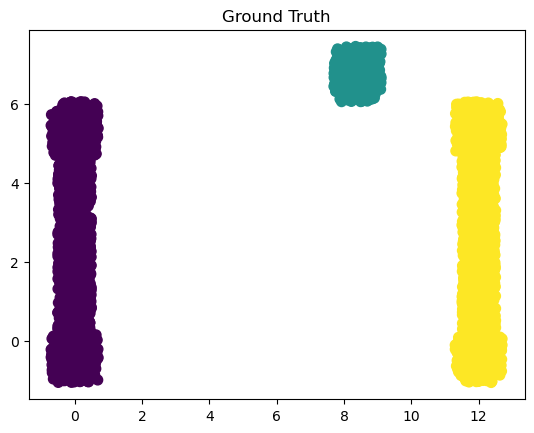

In [4]:
plot_clusters(X, GT, "Ground Truth")

GRID SIZE:  82
Data shape: (6581, 2)
GT shape (6581, 1)
(6581,)
Initialized with NEigs = 10 (type: <class 'int'>)
Pairwise Distance Matrix:
[[ 0.          0.4129825   0.17513431 ... 13.07958604 13.20134421
  12.86265416]
 [ 0.4129825   0.          0.50919649 ... 13.44561683 13.58242315
  13.24331522]
 [ 0.17513431  0.50919649  0.         ... 13.09400794 13.20051993
  12.862353  ]
 ...
 [13.07958604 13.44561683 13.09400794 ...  0.          1.15075662
   1.11439714]
 [13.20134421 13.58242315 13.20051993 ...  1.15075662  0.
   0.34066689]
 [12.86265416 13.24331522 12.862353   ...  1.11439714  0.34066689
   0.        ]]
Transition Matrix:
[[0.00000000e+000 1.00859667e-003 9.87007087e-004 ... 1.72241114e-103
  7.12615543e-106 2.42387374e-098]
 [1.04618310e-003 0.00000000e+000 1.26658119e-003 ... 1.83641303e-112
  2.48683371e-108 5.93003936e-102]
 [2.87866994e-004 4.19249159e-004 0.00000000e+000 ... 4.00370216e-099
  3.58923466e-105 1.83199114e-105]
 ...
 [8.04980871e-104 3.52514199e-108 3.2

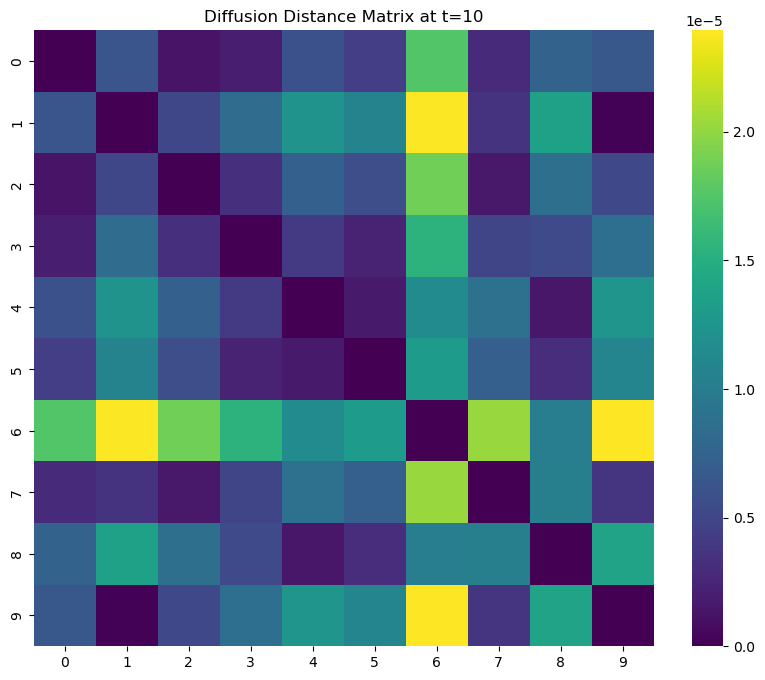

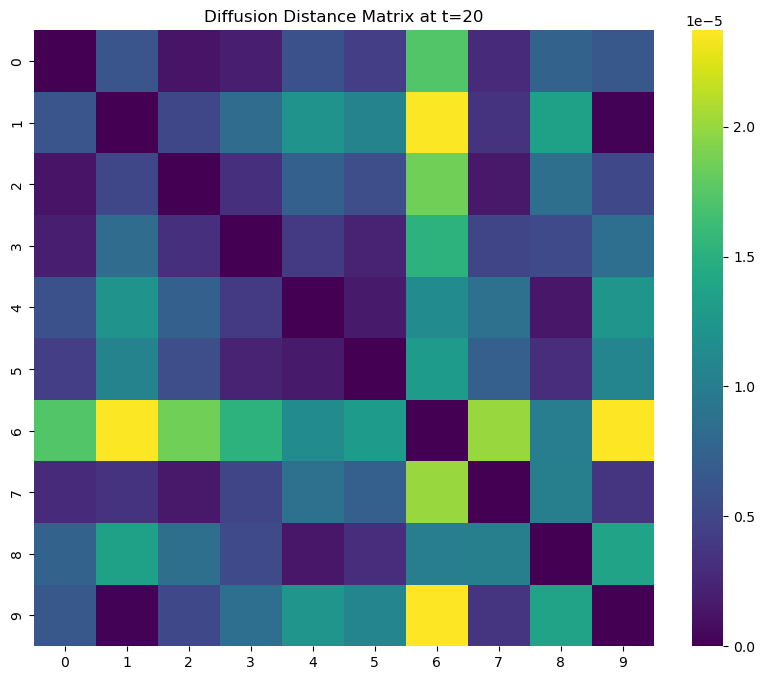

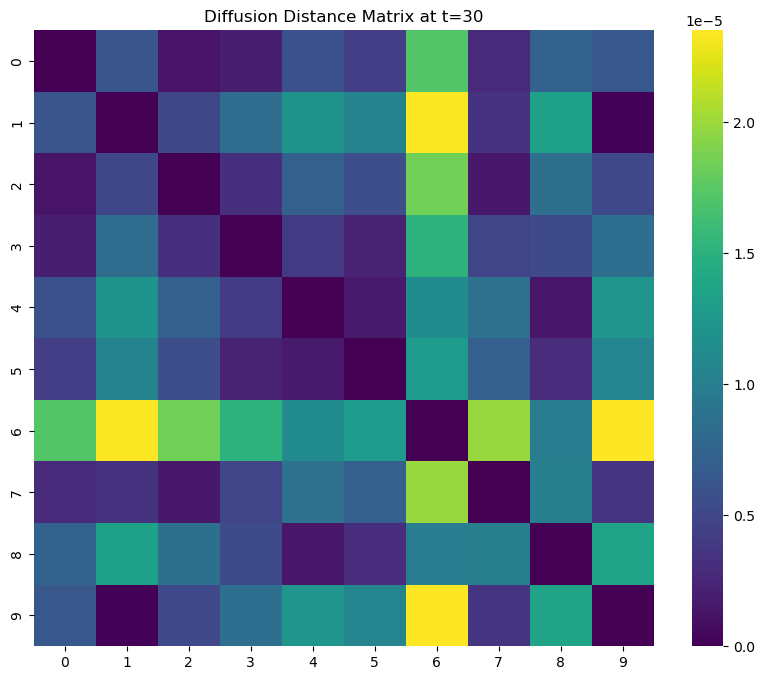

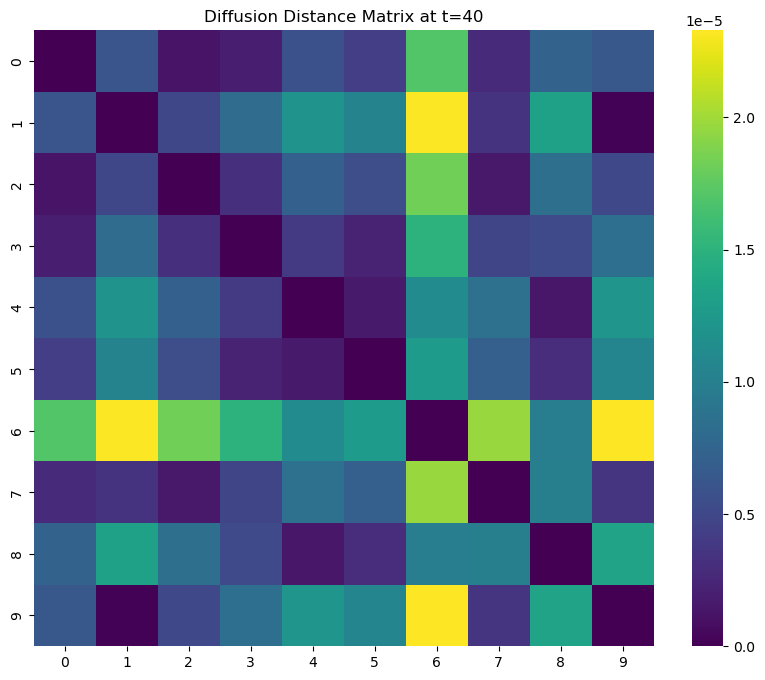

entered lund
Number of Eigenvalues: 10
Number of Eigenvectors: (10, 10)
10
Shape of G['EigenVecs']: (10, 10)
Shape of G['EigenVals']: (10,)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 6581

In [7]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)
print("GT shape", GT.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)
graph_extractor = GraphExtractor(sigma = 0.8600, DiffusionNN = 6578, NEigs= 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep):

    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={timestep}')
    plt.show()


for timestep in [10, 20, 30, 40]:
    plot_diffusion_distance(G, timestep)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 30, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")